# Tuning Pyflex

In this notebook, I'll use some previously computed and process seismic data 
to tune pyflex into selecting the right windows.

In [1]:
import os
import lwsspy as lpy

if not 'workbookDir' in globals():
    workbookDir = os.getcwd()

Defining the cmt directory to get the output waveforms and processing parameters.

In [2]:
cmtdir = os.path.join(workbookDir, "data/C201802271729A")

# Use the initial synthetics, since that's where we start as well.
obsdir = os.path.join(cmtdir, "output/observed")
syndir = os.path.join(cmtdir, "output/synthetic_init")
statio = os.path.join(cmtdir, "output/STATIONS.xml")
cmtsol = os.path.join(cmtdir, "C201802271729A_gcmt3d")

# Current processing parameters
params = lpy.read_yaml_file(os.path.join(cmtdir, "process.yml"))

Define function that reads the traces from the directory

In [3]:
import _pickle as pickle

def read_traces(wtypes, streamdir):
    
    # Initialize dictionary
    d = dict()
    
    # Populate dictionary
    for _wtype in wtypes:
        with open(os.path.join(streamdir, f"{_wtype}_stream.pkl"), 'rb') as f:
            d[_wtype] = pickle.load(f)
    
    return d

Define the wavetypes that are going to be used for the tuning.

In [4]:
from obspy import read_events
wtypes = ["body", "mantle", "surface"]
obsd = read_traces(wtypes, obsdir)
synt = read_traces(wtypes, syndir)
stat = lpy.read_inventory(statio)
cmtsource = lpy.CMTSource.from_CMTSOLUTION_file(cmtsol)
cmtquake = read_events(cmtsol)[0]

That's a lot of traces and we are only interested in a select few so that we can tune
the parameters accordingly

In [5]:
def select_single_station(d: dict, network: str, station: str):
    for _wtype, _stream in d.items():
        d[_wtype] = _stream.select(network=network, station=station)


In [6]:
network = "G" 
station = "INU"
select_single_station(obsd, network=network, station=station)
select_single_station(synt, network=network, station=station)
stat = stat.select(network=network, station=station)

Before moving on to plotting the windows and tuning them let's quickly orient ourselves
by plotting the receiver station geometry.

Event location:    -60.25 N,  150.60 E
Station location:   35.35 N,  137.03 E


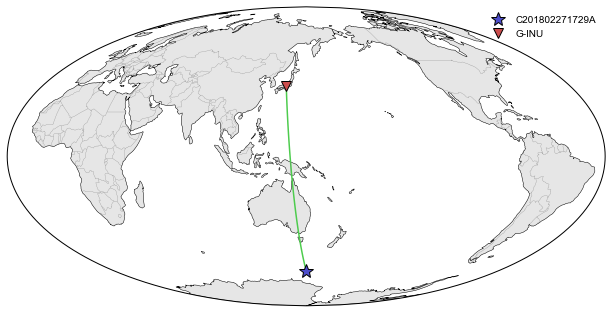

In [7]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

# Marker size
markersize = 10

# Create Map
plt.figure(figsize=(11,5.5))
ax = lpy.map_axes(central_longitude=cmtsource.longitude)
ax.set_global()
lpy.plot_map()

# Plot Event
plt.plot(
    cmtsource.longitude, 
    cmtsource.latitude, 
    marker='*',  lw=0, markerfacecolor=(0.3,0.3,0.8), markersize=markersize*1.5,
    markeredgecolor='k',transform=ccrs.Geodetic(), label="C201802271729A")

# Plot Station
slat, slon = lpy.inv2geoloc(stat)
plt.plot(
    slon, slat,
    marker='v', lw=0, markerfacecolor=(0.8,0.3,0.3), markersize=markersize,
    markeredgecolor='k', transform=ccrs.Geodetic(), label=f"{network}-{station}")

# Plot Great Circle
lat, lon, _ = lpy.gctrack([cmtsource.latitude, slat[0]],  [cmtsource.longitude, slon[0]])
plt.plot(lon, lat, color=(0.3,0.8,0.3), transform=ccrs.Geodetic(), zorder=0)

# Plot Legend
plt.legend(frameon=False)

print(f"Event location:   {cmtsource.latitude:7.2f} N, {cmtsource.longitude:7.2f} E")
print(f"Station location: {slat[0]:7.2f} N, {slon[0]:7.2f} E")

Now that we have loaded all the seismograms, we can plot them
by station, and their respective windows using the current criteria.


### Body Waves

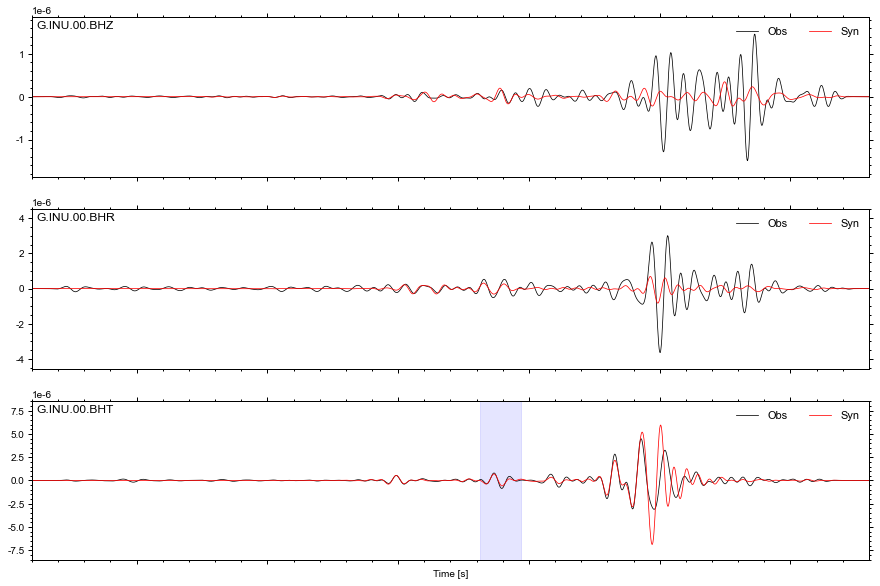

In [8]:
lpy.plot_seismogram_by_station(network, station, obsd["body"], synt["body"], cmtsource=cmtsource)

On the transverse component something is going awefully wrong since, since we do not want to select surface waves.
However, the transverse component clearly selected the Love Wave

### Surface Waves

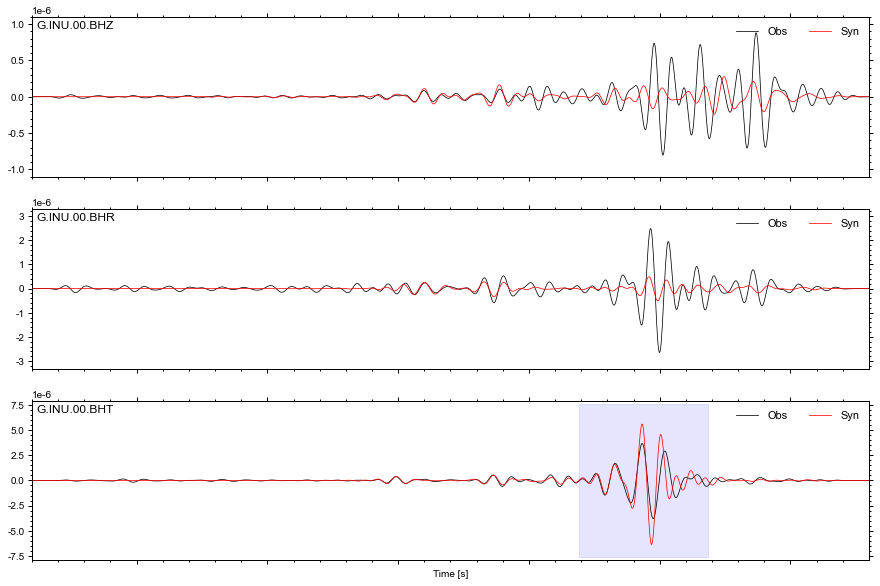

In [9]:
lpy.plot_seismogram_by_station(network, station, obsd["surface"], synt["surface"], cmtsource=cmtsource)

Th surface waves seem to be selected correctly, although the start of the window on the transverse component is rather early as compared to the Love-Wave train

### Mantle

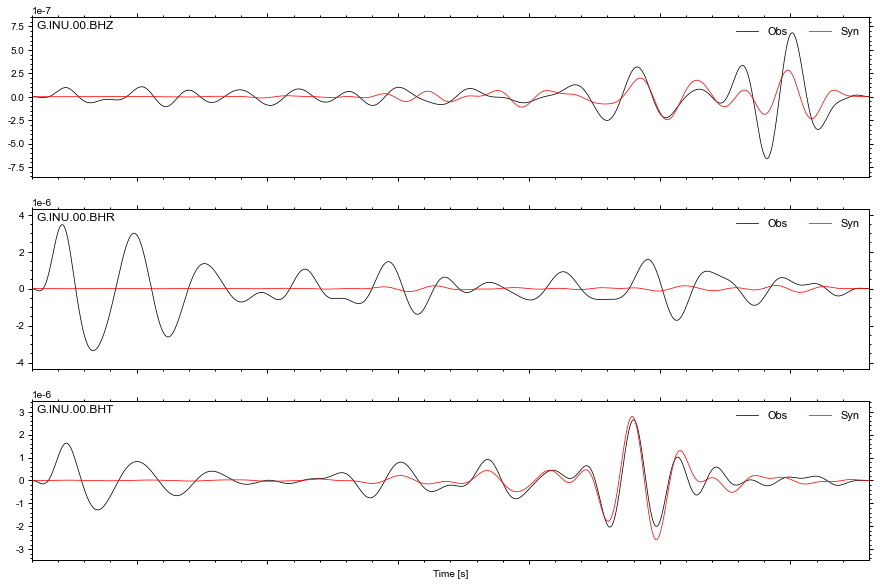

In [10]:
lpy.plot_seismogram_by_station(network, station, obsd["mantle"], synt["mantle"], cmtsource=cmtsource)

## Tweaking PyFlex

Now the part that is actually interesting. Since we have traces, windows, and original parameters at our disposable now, we can just tweak single parameters in the windowing `config` to get what we want. So, let's first take a look at how such a `config` look for the body waves. Note that the parameter file that we are going to look at contains two windowing configs, one for windows prior to the surface waves and one for windows that are behind the surface waves for reflected phases, such as PcP, ScS, PcS, ScS, etc.

In [11]:
from pprint import pprint
pprint(params["body"]["window"][0])

{'components': {'R': {'s2n_limit': 3.5,
                      's2n_limit_energy': 3.5,
                      'snr_max_base': 3.5},
                'T': {'s2n_limit': 3.5,
                      's2n_limit_energy': 3.5,
                      'snr_max_base': 3.5},
                'Z': None},
 'config': {'c_0': 0.7,
            'c_1': 3.0,
            'c_2': 0.0,
            'c_3a': 1.0,
            'c_3b': 2.0,
            'c_4a': 3.0,
            'c_4b': 10.0,
            'cc_acceptance_level': 0.85,
            'check_global_data_quality': True,
            'dlna_acceptance_level': 0.8,
            'dlna_reference': 0.0,
            'earth_model': 'ak135',
            'max_period': 100.0,
            'max_surface_wave_velocity': 4.1,
            'max_time_after_last_arrival': 200.0,
            'max_time_before_first_arrival': 100.0,
            'min_period': 50.0,
            'min_surface_wave_velocity': 3.2,
            'resolution_strategy': 'interval_scheduling',
            's2n_li

There is an ample amount of tweakable parameters, but the main interesting ones are going to be start and end of the surface wave train as defined by their surface velocities, and min and max time before and after arrival.
Note that we can also tweak the algorithm by setting certain values component specific.

First let's make a copy of the observed and synthetic data and remove any windows.


In [13]:
def clear_windows(d: dict):
    for _wtype, _stream in d.items():
        for _tr in _stream:
            _tr.stats.windows = []
            _tr.stats.tapers = []


def clear_windows_wtype(d: dict, wtype: str):
    stream = d[wtype]
    for _tr in stream:
        _tr.stats.windows = []
        _tr.stats.tapers = []

def check_windows(d: dict):
    for _wtype, _stream in d.items():
        for _tr in _stream:
            if len(_tr.stats.windows) != 0:
                print(_tr.id, len(_tr.stats.windows))

In [14]:
from copy import deepcopy

nobsd = deepcopy(obsd)
nsynt = deepcopy(synt)

clear_windows(nobsd)



R


Length of windowobs: 1
Station G.INU.00.BHR picked 0 windows
Win on trace: []


T


Length of windowobs: 1
Station G.INU.00.BHT picked 2 windows
Win on trace: [Window(left=855, right=930, center=892, channel_id=G.INU.00.BHT, max_cc_value=0.9517309665679932, cc_shift=0, dlnA=0.2388227880001068), Window(left=971, right=1035, center=1003, channel_id=G.INU.00.BHT, max_cc_value=0.964542806148529, cc_shift=-1, dlnA=0.7745164632797241)]


Z


Length of windowobs: 1


/Users/lucassawade/anaconda3/envs/lwsspy/lib/python3.8/site-packages/pyflex/window_selector.py:1154: UserWarning: The amplitude difference between data andsynthetic is fairly large.
  warnings.warn("The amplitude difference between data and"


Station G.INU.00.BHZ picked 1 windows
Win on trace: [Window(left=834, right=941, center=887, channel_id=G.INU.00.BHZ, max_cc_value=0.8377684354782104, cc_shift=2, dlnA=-0.14657285809516907)]


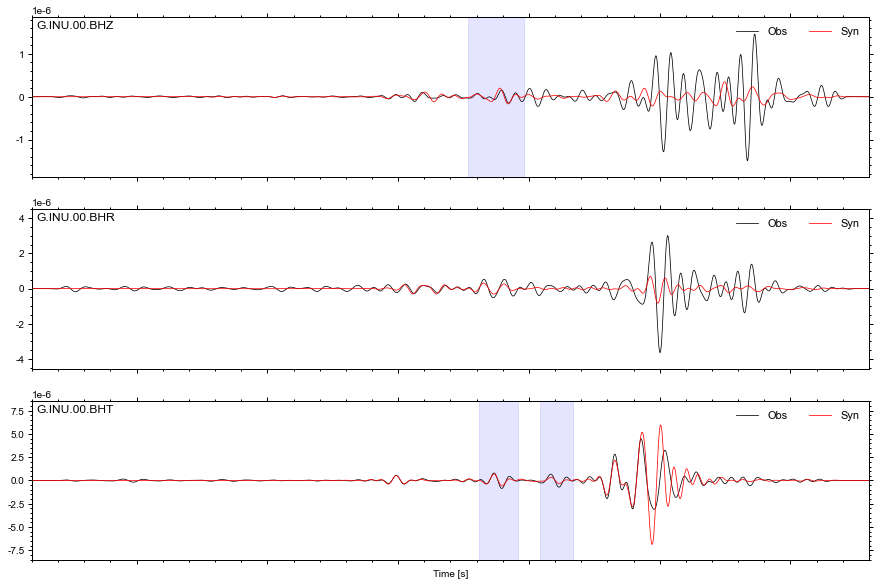

In [15]:
wtype = 'body'

clear_windows_wtype(nobsd, wtype)

# Modify the parameters here
nparams = deepcopy(params[wtype]["window"][0])
nparams['components']['T']['max_surface_wave_velocity'] = 5.0
nparams['config']['min_surface_wave_velocity'] = 3.1
nparams['config']['max_time_after_last_arrival'] = 0.0
nparams['config']['max_time_before_first_arrival'] = 0.0
nparams['config']['min_period'] = 40.0
nparams['config']['max_period'] = 150.0
nparams['config']['stalta_waterlevel'] = 0.085

nparams['config']['cc_acceptance_level'] = 0.8
nparams['config']['check_global_data_quality'] = True
nparams['config']['dlna_acceptance_level'] = 0.8
nparams['config']['dlna_reference'] = 0.0
nparams['config']['earth_model'] = 'ak135'
nparams['config']['resolution_strategy'] = 'interval_scheduling'
nparams['config']['s2n_limit'] = 5.0
nparams['config']['s2n_limit_energy'] = 5.0
nparams['config']['snr_integrate_base'] = 3.5
nparams['config']['snr_max_base'] = 6.0
nparams['config']['tshift_acceptance_level'] = 10.0
nparams['config']['tshift_reference'] = 0.0
nparams['config']['window_signal_to_noise_type'] = 'amplitude'
nparams['config']['c_0'] = 0.7
nparams['config']['c_1'] = 2.0 
nparams['config']['c_2'] = 0.3
nparams['config']['c_3a'] = 1.0
nparams['config']['c_3b'] = 2.0
nparams['config']['c_4a'] = 3.0
nparams['config']['c_4b'] = 10.0

nobsd[wtype] = lpy.window_on_stream(nobsd[wtype], nsynt[wtype], nparams, station=stat, event=cmtquake, _verbose=True)

lpy.plot_seismogram_by_station(network, station, nobsd["body"], synt["body"], cmtsource=cmtsource)

/Users/lucassawade/anaconda3/envs/lwsspy/lib/python3.8/site-packages/pyflex/window_selector.py:1154: UserWarning: The amplitude difference between data andsynthetic is fairly large.
  warnings.warn("The amplitude difference between data and"


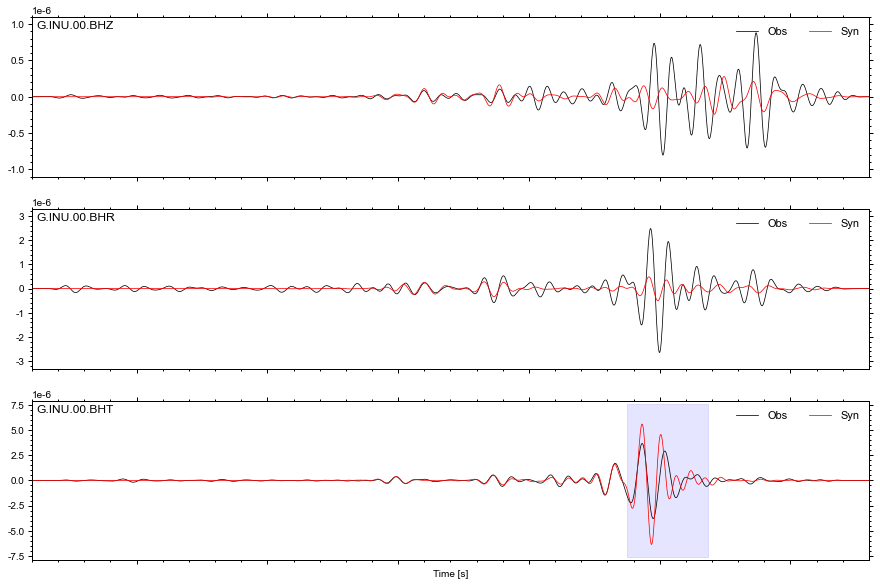

In [16]:
wtype = 'surface'

clear_windows_wtype(nobsd, wtype)

# Modify the parameters here
nparams = deepcopy(params[wtype]["window"][0])
nparams['components']['T']['max_surface_wave_velocity'] = 4.45
nparams['config']['min_surface_wave_velocity'] = 3.1
nparams['config']['max_time_after_last_arrival'] = 0.0
nparams['config']['max_time_before_first_arrival'] = 0.0



nobsd[wtype] = lpy.window_on_stream(nobsd[wtype], nsynt[wtype], nparams, station=stat, event=cmtquake)

lpy.plot_seismogram_by_station(network, station, nobsd[wtype], nsynt[wtype], cmtsource=cmtsource)



R


Length of windowobs: 1


/Users/lucassawade/anaconda3/envs/lwsspy/lib/python3.8/site-packages/pyflex/window_selector.py:1154: UserWarning: The amplitude difference between data andsynthetic is fairly large.
  warnings.warn("The amplitude difference between data and"
[2021-05-27 14:34:42,137] - pyflex - WARNING: Whole waveform rejected as the integrated signal to noise ratio (0.108831) is above the threshold (3.500000). No window will be selected.


Station G.INU.00.BHR picked 0 windows
Win on trace: []


T


Length of windowobs: 1


[2021-05-27 14:34:42,364] - pyflex - WARNING: Whole waveform rejected as the integrated signal to noise ratio (0.764867) is above the threshold (3.500000). No window will be selected.


Station G.INU.00.BHT picked 0 windows
Win on trace: []


Z


Length of windowobs: 1
Station G.INU.00.BHZ picked 0 windows
Win on trace: []


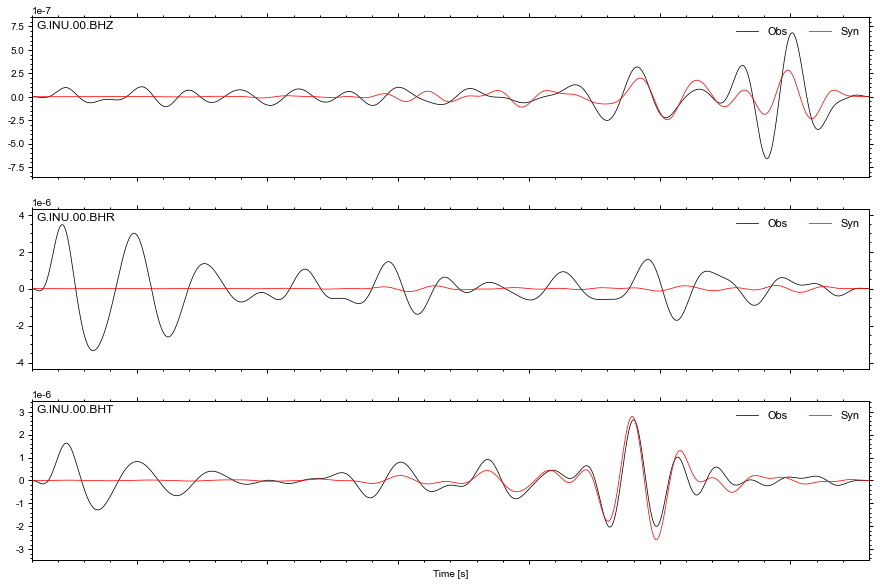

In [17]:
wtype = 'mantle'

clear_windows_wtype(nobsd, wtype)

# Modify the parameters here
nparams = deepcopy(params[wtype]["window"][0])
nparams['config']['cc_acceptance_level'] = 0.8
nparams['config']['check_global_data_quality'] = True
nparams['config']['dlna_acceptance_level'] = 0.8
nparams['config']['dlna_reference'] = 0.0
nparams['config']['earth_model'] = 'ak135'
nparams['config']['max_period'] = 350.0
nparams['config']['max_surface_wave_velocity'] = 4.5
nparams['config']['max_time_after_last_arrival'] = 50.0
nparams['config']['max_time_before_first_arrival'] = 50.0
nparams['config']['min_period'] = 100.0
nparams['config']['min_surface_wave_velocity'] = 3.1
nparams['config']['resolution_strategy'] = 'interval_scheduling'
nparams['config']['s2n_limit'] = 5.0
nparams['config']['s2n_limit_energy'] = 5.0
nparams['config']['selection_mode'] = 'surface_waves'
nparams['config']['snr_integrate_base'] = 3.5
nparams['config']['snr_max_base'] = 6.0
nparams['config']['stalta_waterlevel'] = 0.085
nparams['config']['tshift_acceptance_level'] = 25.0
nparams['config']['tshift_reference'] = 0.0
nparams['config']['window_signal_to_noise_type'] = 'amplitude'
nparams['config']['c_0'] = 0.7
nparams['config']['c_1'] = 4.0 
nparams['config']['c_2'] = 0.3
nparams['config']['c_3a'] = 1.0
nparams['config']['c_3b'] = 2.0
nparams['config']['c_4a'] = 3.0
nparams['config']['c_4b'] = 10.0
# nparams['config']['cc_acceptance_level'] = 0.25


nobsd[wtype] = lpy.window_on_stream(nobsd[wtype], nsynt[wtype], nparams, station=stat, event=cmtquake, _verbose=True)

lpy.plot_seismogram_by_station(network, station, nobsd[wtype], nsynt[wtype], cmtsource=cmtsource)

In [153]:
nparams

{'components': {'R': None,
  'T': {'max_surface_wave_velocity': 4.45, 'min_surface_wave_velocity': 3.8},
  'Z': None},
 'config': {'c_0': 0.7,
  'c_1': 4.0,
  'c_2': 0.2,
  'c_3a': 1.0,
  'c_3b': 2.0,
  'c_4a': 3.0,
  'c_4b': 10.0,
  'cc_acceptance_level': 0.8,
  'check_global_data_quality': True,
  'dlna_acceptance_level': 0.8,
  'dlna_reference': 0.0,
  'earth_model': 'ak135',
  'max_period': 300.0,
  'max_surface_wave_velocity': 5.0,
  'max_time_after_last_arrival': 0.0,
  'max_time_before_first_arrival': 0.0,
  'min_period': 150.0,
  'min_surface_wave_velocity': 3.1,
  'resolution_strategy': 'interval_scheduling',
  's2n_limit': 5.0,
  's2n_limit_energy': 5.0,
  'selection_mode': 'surface_waves',
  'snr_integrate_base': 3.5,
  'snr_max_base': 6.0,
  'stalta_waterlevel': 0.085,
  'tshift_acceptance_level': 25.0,
  'tshift_reference': 0.0,
  'window_signal_to_noise_type': 'amplitude'}}

array([ 150.,  100.,   50.,   40.])

In [278]:
pprint(params["mantle"])

{'process': {'filter_flag': True,
             'pre_filt': [0.002857142857142857,
                          0.0033333333333333335,
                          0.006666666666666667,
                          0.008],
             'relative_endtime': 3300,
             'relative_starttime': 100,
             'resample_flag': True,
             'rotate_flag': True,
             'sampling_rate': 0.5,
             'sanity_check': True,
             'taper_percentage': 0.05,
             'taper_type': 'cosine',
             'water_level': 100.0},
 'weight': 0.20306693876236437,
 'window': [{'components': {'R': None,
                            'T': {'max_surface_wave_velocity': 6.5,
                                  'min_surface_wave_velocity': 3.8},
                            'Z': None},
             'config': {'c_0': 0.7,
                        'c_1': 4.0,
                        'c_2': 0.2,
                        'c_3a': 1.0,
                        'c_3b': 2.0,
                        'c

3200.0